In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.regularizers import l1
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

#**PART 1: DATA ANALYSIS FOR TRAINING**

###READING THE DATA FROM THE DRIVE

In [4]:
columns = ['unit_no', 'cycles', 'oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/train_FD003.txt"), sep ='\s+', header=None, names = columns)
df_test = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/test_FD003.txt"), sep ='\s+', header=None, names = columns)
df_RUL = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/RUL_FD003.txt"), sep ='\s+', header=None, names = ['RUL'])

In [5]:
df_train.isnull().sum()

unit_no    0
cycles     0
oc_1       0
oc_2       0
oc_3       0
s_1        0
s_2        0
s_3        0
s_4        0
s_5        0
s_6        0
s_7        0
s_8        0
s_9        0
s_10       0
s_11       0
s_12       0
s_13       0
s_14       0
s_15       0
s_16       0
s_17       0
s_18       0
s_19       0
s_20       0
s_21       0
dtype: int64

###*Hence, we see that the data is clean, has no NaN, nor does it have any blank cells.*



###The below line of code finds the maximum number of cycles each unit of engine takes until failure. This will be useful to make the "Remaining Useful Life" column

In [6]:
max_cycles_train = df_train.groupby(['unit_no'], sort=False)['cycles'].max().reset_index().rename(columns={'cycles':'MaxCycleID'})

###In the below cell, we are adding 2 new columns to the Dataframe, namely "MaxCycleID" and "RUL". "MaxCycleID" is the total number of cycles the unit took to fail. Then we subtract the number of cycles that have been performed, from the total number of cycles the unit took to fail.This gives the Remaining Useful Life, which is stored in the column "RUL".

In [7]:
df_train = pd.merge(df_train, max_cycles_train, how='inner', on='unit_no')
df_train['RUL'] = df_train['MaxCycleID'] - df_train['cycles']
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,MaxCycleID,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,259,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,259,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,259,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,259,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,259,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,152,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,152,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,152,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,152,1


In [8]:
print(np.max(np.array(df_train['MaxCycleID'])))

525


###Now we delete the column "MaxCycleID", since we have found the RUL.

In [9]:
df_train = df_train.drop(labels='MaxCycleID', axis=1)
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,1


###IN THE BELOW CELL, WE ARE SAVING THE COLUMN FOR REMIANING USEFUL LIFE IN THE VARIABLE 'RUL'. THEN WE CONVERT THIS ARRAY INTO A DATAFRAME AND SAVE IT IN THE VARIABLE "df_train_y_final" FOR FUTURE USE. WE THEN SAVE THE COLUMNS "cycles", & "unit_no" IN THE VARIABLES "cycles" & "unit". NOW WE DROP THESE COLUMNS, TO GET THE DATASET WITH ONLY OPERATIONAL CONDITIONS AND SENSOR READINGS, i.e. THE DATA POINTS THAT MAY PLAY A ROLE IN PREDICTION.

In [10]:
unit= df_train['unit_no'].values
unit = unit[~np.isnan(unit)]
L= len(unit)
RUL= df_train['RUL'].values
RUL= RUL[~np.isnan(RUL)]

################################################################
df_train_y_final = pd.DataFrame(RUL)
################################################################

cycles = df_train['cycles'].values
df_train_temp = df_train.drop(labels={'RUL','unit_no','cycles'}, axis=1)
df_train_temp

,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


###IN THE BELOW CELL, WE USE THE LIBRARY FUNCTION, "StandardScaler" TO SCALE AND NORMALIZE THE DATA. THEN WE INSERT THE COLUMNS "unit_no" AND "cycles" BACK INTO THE DATAFRAME FOR PLOTTING. WE SAVE THE SCALED DATASET IN THE VARIABLE "df_train_scaled".

In [11]:
sc = StandardScaler()
df_train_temp = sc.fit_transform(df_train_temp)
df_train_temp = pd.DataFrame(df_train_temp)
df_train_temp
df_train_temp.columns =['oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21'] 
df_train_temp.insert(0, "unit_no", unit, True) 
df_train_temp.insert(1, "cycles", cycles, True) 

df_train_scaled = df_train_temp

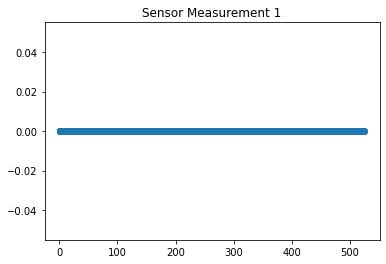

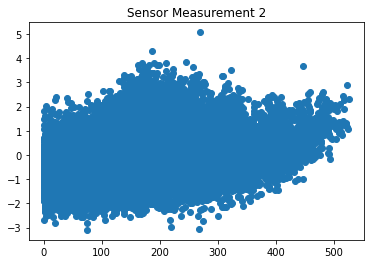

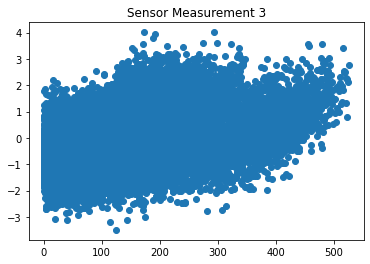

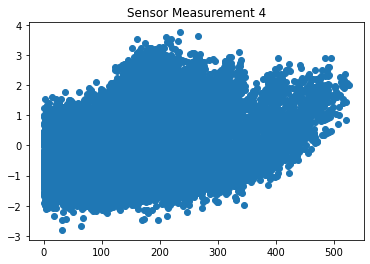

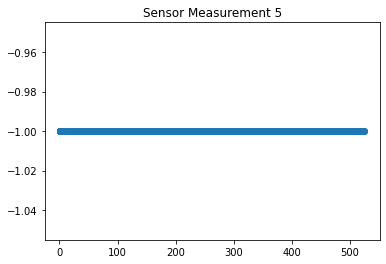

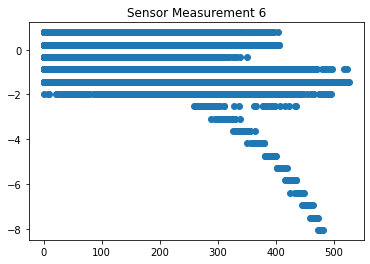

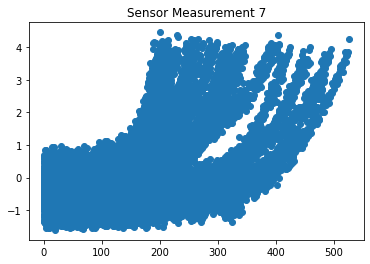

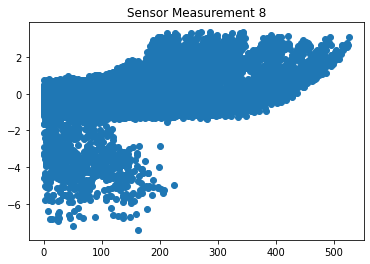

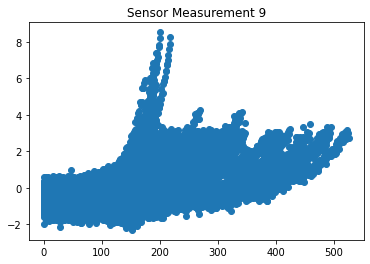

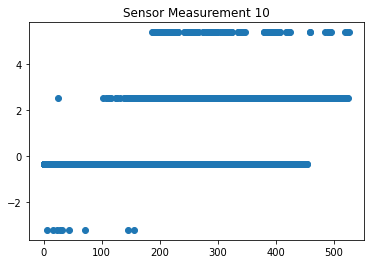

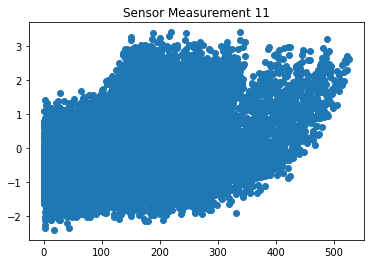

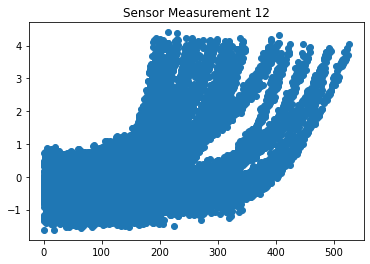

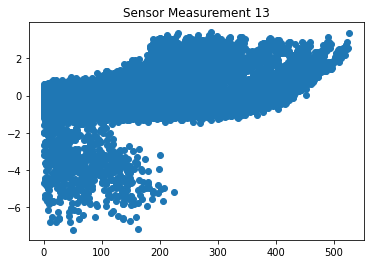

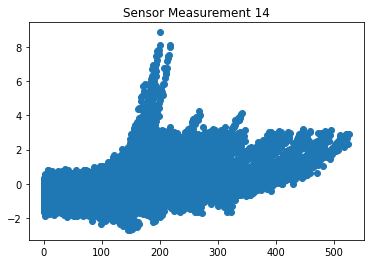

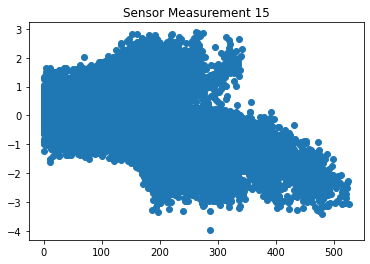

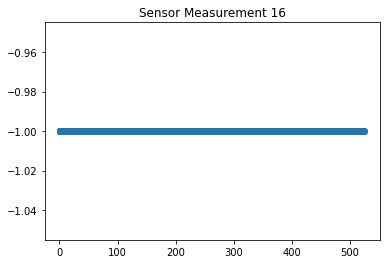

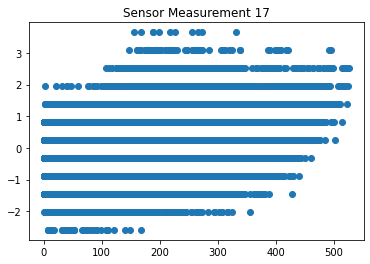

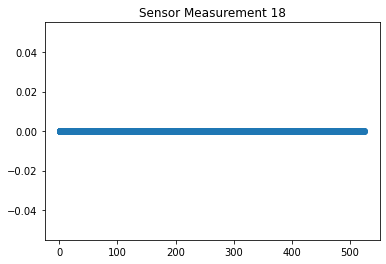

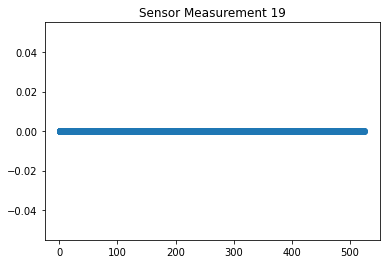

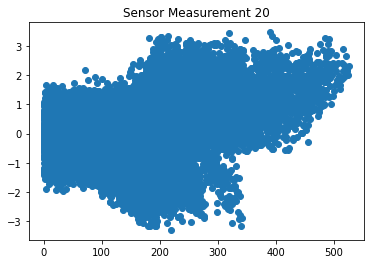

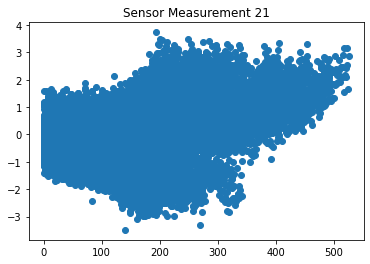

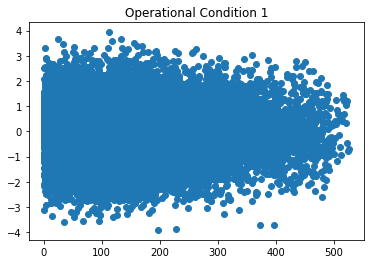

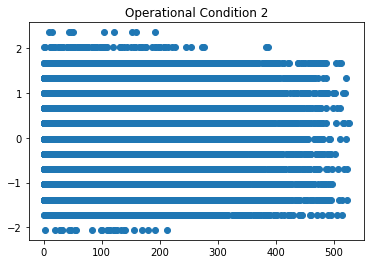

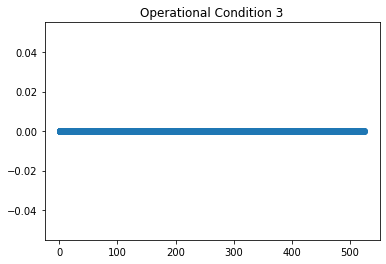

In [12]:
for i in range(1,22):
    plt.figure()
    temp= df_train_scaled['s_'+str(i)].values
    temp= temp[~np.isnan(temp)]
    plt.scatter(cycles,temp)
    plt.title('Sensor Measurement '+str(i))
    plt.show(block= False)
for i in range(1,4):
    plt.figure()
    temp= df_train_scaled['oc_'+str(i)].values
    plt.scatter(cycles,temp)
    plt.title('Operational Condition '+str(i))
    plt.show(block= False)

### FROM THE ABOVE PLOTS WE SEE THAT READINGS FROM SENSORS 1, 5, 16, 18 & 19 REMAIN CONSTANT ALWAYS AND SO CAN BE DROPPED WHILE TRAINING THE MODEL.

In [13]:
from random import randrange
p = np.zeros(5)
for i in range(5):
    p[i] = randrange(100)
print(p)

[ 5. 97. 23.  5.  8.]


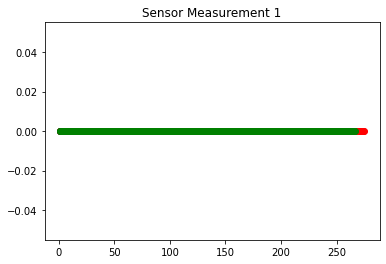

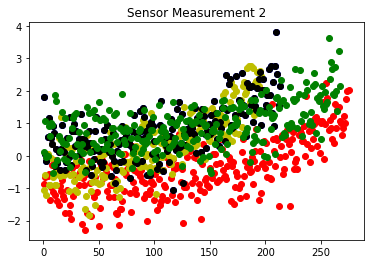

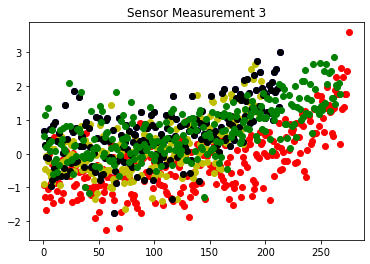

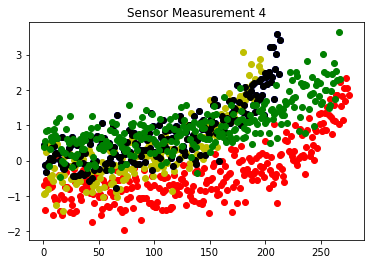

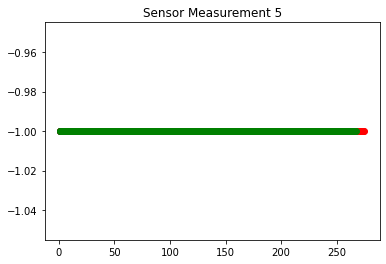

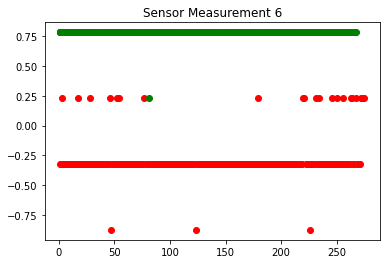

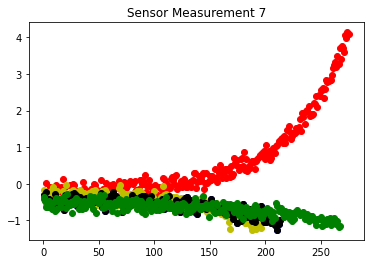

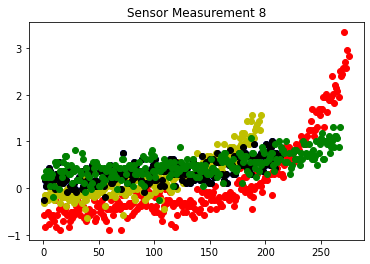

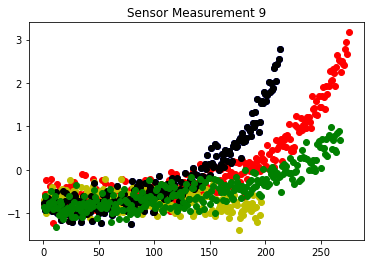

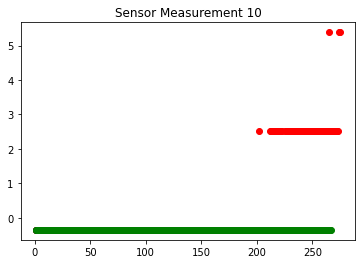

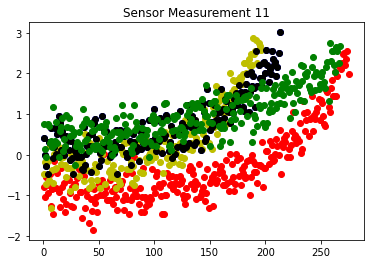

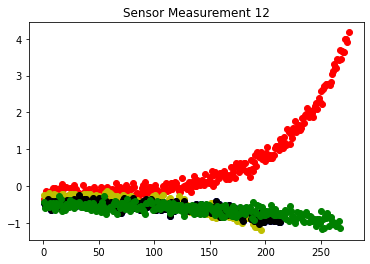

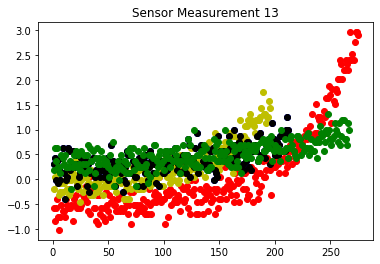

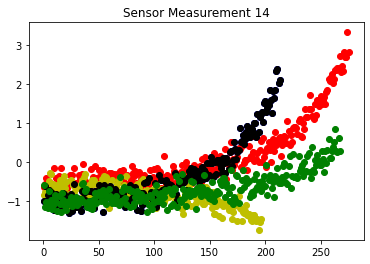

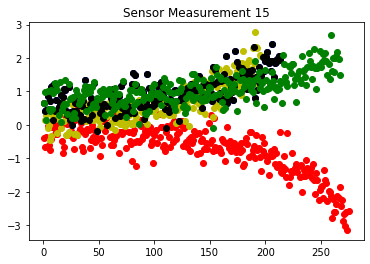

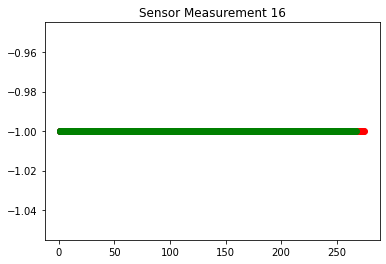

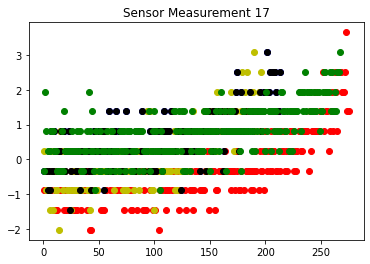

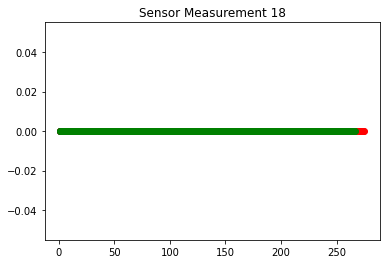

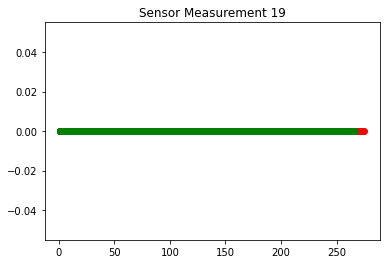

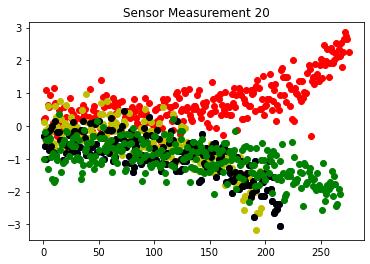

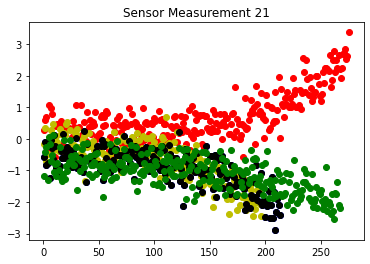

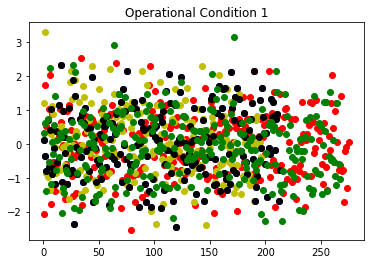

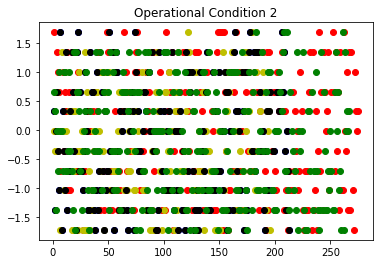

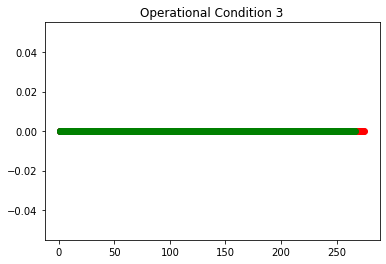

In [14]:
for i in range(1,22):
    plt.figure()
    for j,col in [[p[0],'b'],[p[1],'r'],[p[2],'y'],[p[3],'black'],[p[4],'g']]:
        data_unit = df_train_scaled[df_train['unit_no'] == j] 
        cycles_unit = data_unit['cycles'].values
        temp= data_unit['s_'+str(i)].values
        temp= temp[~np.isnan(temp)]
        plt.scatter(cycles_unit,temp, c = col)
    plt.title('Sensor Measurement '+str(i))
    plt.show(block= False)
for i in range(1,4):
    plt.figure()
    for j,col in [[p[0],'b'],[p[1],'r'],[p[2],'y'],[p[3],'black'],[p[4],'g']]:
        data_unit = df_train_scaled[df_train['unit_no'] == j] 
        cycles_unit = data_unit['cycles'].values
        temp= data_unit['oc_'+str(i)].values
        temp= temp[~np.isnan(temp)]
        plt.scatter(cycles_unit,temp, c = col)
    plt.title('Operational Condition '+str(i))
    plt.show(block= False)


In [15]:
S= np.ndarray(shape=(L,0))
sen = [2,3,4,7,11,12, 15,17]

num_sen= len(sen)
for i in sen:
    temp= df_train_scaled['s_' + str(i)].values
    temp = temp[~np.isnan(temp)].reshape(L, 1)
    S= np.hstack((S,temp))

In [16]:
df_train_x_final = pd.DataFrame(S)
df_train_x_final.columns =['s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17'] 
####################################################################################################
df_train_x_final
####################################################################################################

,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,-0.187102,-0.712038,-0.780848,-0.341494,-0.385602,-0.227593,0.469741,-0.889364
1,0.080574,-0.497656,-0.775732,-0.172755,-0.618882,-0.193802,0.729201,-0.321641
2,-0.531256,-0.841254,0.116524,-0.207667,-0.652208,-0.313608,-0.100409,-0.889364
3,0.883602,-0.362566,-1.248464,0.019257,-0.585556,-0.172298,-0.138419,-0.321641
4,-1.487242,0.080881,-0.697966,-0.117479,-0.885488,-0.144650,-0.153292,-0.321641
...,...,...,...,...,...,...,...,...
24715,2.527897,1.164537,2.009498,-0.955353,2.846998,-1.041663,1.775302,0.813805
24716,1.591031,1.218867,2.524183,-0.955353,2.380437,-0.964864,2.003362,1.381528
24717,2.642615,2.415587,2.756456,-1.118272,2.547066,-1.109246,2.084340,1.949251
24718,2.833812,1.392134,2.261213,-1.295739,2.113831,-0.934145,1.960394,1.381528


Text(0, 0.5, 'Cumulative explained variance')

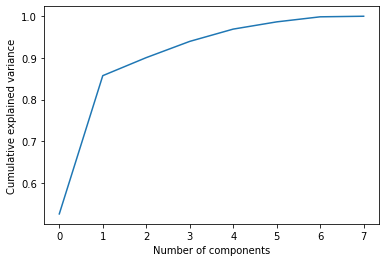

In [17]:
pca = PCA(n_components=8)
pca.fit(df_train_x_final)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

##[78. 52. 40. 76. 25.]

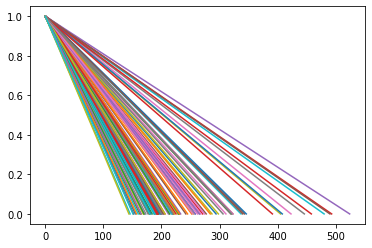

In [24]:
num_sen= len(sen)
df_train_x_final = np.array(df_train_x_final)
one = np.ones((df_train_x_final.shape[0],1))
df_train_x_final = np.hstack((one,df_train_x_final))

Ti= [ ]
Health_Parameter= np.ndarray(shape=(0,1))
# M= np.ndarray(shape=(100,2))
for i in range(1,101):
    ind= np.where(unit==i)[0]
    Ti.append(len(ind)) # To be used later in the testing phase
    temp= np.linspace(1, 0, len(ind), dtype=float).reshape(len(ind),1)
    plt.plot(range(len(temp)), temp)
    Health_Parameter= np.vstack((Health_Parameter,temp))


In [32]:
lm= LinearRegression()
lm.fit(df_train_x_final,Health_Parameter)
print(lm.coef_)

[[ 0.         -0.02672559 -0.0332993  -0.0588123   0.00056718 -0.07443264
  -0.01070642  0.06318948 -0.04116645]]


In [ ]:
test_data = X[100,:]
print(test_data)
print(mode      l.predict(test_data.reshape(1,6), batch_size = 1))
print(y[100])

[ 0.31001074 -0.24656476 -0.43295004 -0.38889272 -0.68553345 -0.389857  ]
[[0.65913546]]
[0.6124031]
